End effector position: Matrix([[1.00000000000000], [0], [0]])


Pitch angle omega: 180.0 degrees


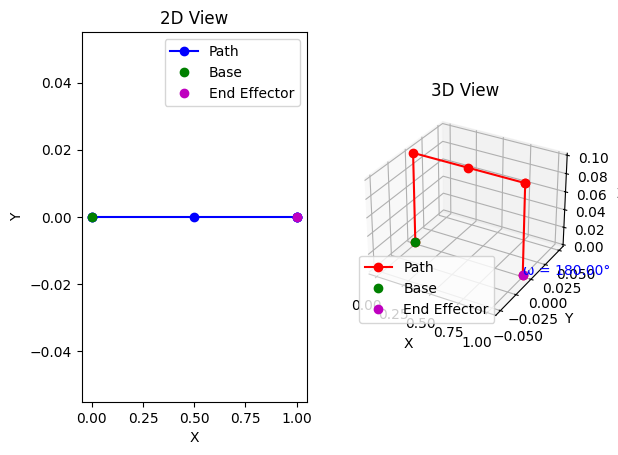

In [49]:
import numpy as np
from sympy import symbols, cos, sin, pi, Matrix, N
import matplotlib.pyplot as plt
import math

# Define symbolic variables
theta1, theta2, theta3, theta4, theta5 = symbols("theta1 theta2 theta3 theta4 theta5")

# DH Parameters
d1, a1, alpha1 = 0.1, 0, pi / 2
d2, a2, alpha2 = 0, 0.5, 0
d3, a3, alpha3 = 0, 0.5, 0
d4, a4, alpha4 = 0, 0, pi / 2
d5, a5, alpha5 = 0.1, 0, 0


# Define the transformation matrix function using DH parameters
def DH_matrix(theta, d, a, alpha):
    return Matrix(
        [
            [
                cos(theta),
                -sin(theta) * cos(alpha),
                sin(theta) * sin(alpha),
                a * cos(theta),
            ],
            [
                sin(theta),
                cos(theta) * cos(alpha),
                -cos(theta) * sin(alpha),
                a * sin(theta),
            ],
            [0, sin(alpha), cos(alpha), d],
            [0, 0, 0, 1],
        ]
    )


# Joint angles in degrees
theta_in_degrees = {
    "theta1": 0,
    "theta2": 0,
    "theta3": 0,
    "theta4": 0,
    "theta5": 0,
}

# Convert angles to radians
angles = {key: math.radians(value) for key, value in theta_in_degrees.items()}

# Compute transformation matrices
T1 = DH_matrix(theta1, d1, a1, alpha1).subs(angles)
T2 = DH_matrix(theta2, d2, a2, alpha2).subs(angles)
T3 = DH_matrix(theta3, d3, a3, alpha3).subs(angles)
T4 = DH_matrix(theta4, d4, a4, alpha4).subs(angles)
T5 = DH_matrix(theta5, d5, a5, alpha5).subs(angles)

# Calculate cumulative transformations
T01 = T1
T02 = T01 * T2
T03 = T02 * T3
T04 = T03 * T4
T05 = T04 * T5

# Extract positions
positions = [
    Matrix([0, 0, 0, 1]),  # Base
    T01[:3, 3],
    T02[:3, 3],
    T03[:3, 3],
    T04[:3, 3],
    T05[:3, 3],  # End effector
]
positions = [N(p) for p in positions]  # Evaluate numerically

# Calculate omega (pitch angle) from the final orientation matrix
R05 = T05[:3, :3]
omega = math.degrees(math.atan2(R05[2, 0], R05[2, 2]))

# Plotting
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

# 2D plot
x_vals = [p[0] for p in positions]
y_vals = [p[1] for p in positions]
ax1.plot(x_vals, y_vals, "bo-")
ax1.plot(x_vals[0], y_vals[0], "go")  # Base in green
ax1.plot(x_vals[-1], y_vals[-1], "mo")  # End effector in magenta
ax1.set_title("2D View")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(["Path", "Base", "End Effector"])

# 3D plot
x_vals = [p[0] for p in positions]
y_vals = [p[1] for p in positions]
z_vals = [p[2] for p in positions]
ax2.plot(x_vals, y_vals, z_vals, "ro-")
ax2.plot(x_vals[0], y_vals[0], z_vals[0], "go")  # Base in green
ax2.plot(x_vals[-1], y_vals[-1], z_vals[-1], "mo")  # End effector in magenta

# Annotate omega
ax2.text(x_vals[-1], y_vals[-1], z_vals[-1], f"ω = {omega:.2f}°", color="blue")

ax2.set_title("3D View")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.legend(["Path", "Base", "End Effector"])

print(f"End effector position: {positions[-1]}")
print("\n")
# print(f"End effector orientation: {T05[:3, :3]}")
print(f"Pitch angle omega: {omega} degrees")

plt.show()


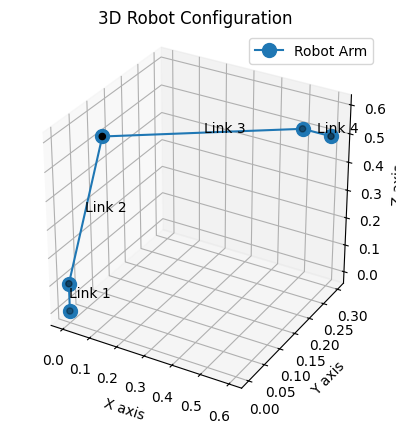

Theta1: 30.96 degrees
Theta2: 79.45 degrees
Theta3: -90.00 degrees
Theta4: 190.55 degrees
Joint positions: [(0, 0, 0), (0, 0, 0.1), (0.07850141485749113, 0.04710084891449468, 0.591547594742265), (0.49999999999999994, 0.3, 0.5), (0.6, 0.3, 0.5)]
End effector position: (0.6, 0.3, 0.5)
Theta1: 0.54 radians, Theta2: 1.39 radians, Theta3: -1.57 radians, Theta4: 3.33 radians


In [59]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


class RobotArm:
    def __init__(self, d1, a2, a3, d5):
        self.d1 = d1
        self.a2 = a2
        self.a3 = a3
        self.d5 = d5

    def inverse_kinematics(self, Px, Py, Pz, omega):
        R = self.d5 * math.cos(math.radians(omega))
        theta1 = math.degrees(math.atan2(Py, Px))

        Pxw = Px - R * math.cos(math.radians(theta1))
        Pyw = Py - R * math.sin(math.radians(theta1))
        Pzw = Pz + self.d5 * math.sin(math.radians(omega))

        Rw = math.sqrt(Pxw**2 + Pyw**2)
        S = math.sqrt((Pzw - self.d1) ** 2 + Rw**2)

        alpha = math.degrees(math.atan2(Pzw - self.d1, Rw))
        beta = math.degrees(
            math.acos((self.a2**2 + S**2 - self.a3**2) / (2 * self.a2 * S))
        )

        theta2 = alpha + beta
        theta2_alt = alpha - beta

        theta3 = math.degrees(
            math.acos((S**2 - self.a2**2 - self.a3**2) / (2 * self.a2 * self.a3))
        )
        theta3 = -theta3

        theta234 = 90 - omega
        theta4 = theta234 - theta2 - theta3

        return theta1, theta2, theta3, theta4

    def forward_kinematics(self, theta1, theta2, theta3, theta4):
        theta1 = math.radians(theta1)
        theta2 = math.radians(theta2)
        theta3 = math.radians(theta3)
        theta4 = math.radians(theta4)

        x0, y0, z0 = 0, 0, 0
        x1, y1, z1 = 0, 0, self.d1
        x2 = self.a2 * math.cos(theta1) * math.cos(theta2)
        y2 = self.a2 * math.sin(theta1) * math.cos(theta2)
        z2 = self.d1 + self.a2 * math.sin(theta2)
        x3 = x2 + self.a3 * math.cos(theta1) * math.cos(theta2 + theta3)
        y3 = y2 + self.a3 * math.sin(theta1) * math.cos(theta2 + theta3)
        z3 = z2 + self.a3 * math.sin(theta2 + theta3)

        x4 = x3 + self.d5
        y4 = y3
        z4 = z3 

        return [(x0, y0, z0), (x1, y1, z1), (x2, y2, z2), (x3, y3, z3), (x4, y4, z4)]

    def plot_robot(self, joint_positions):
        x, y, z = zip(*joint_positions)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(x, y, z, "o-", markersize=10, label="Robot Arm")
        ax.scatter(x, y, z, c="k")

        for i in range(len(joint_positions) - 1):
            ax.text(
                (x[i] + x[i + 1]) / 2,
                (y[i] + y[i + 1]) / 2,
                (z[i] + z[i + 1]) / 2,
                f"Link {i + 1}",
                color="black",
            )

        ax.set_xlabel("X axis")
        ax.set_ylabel("Y axis")
        ax.set_zlabel("Z axis")
        ax.set_title("3D Robot Configuration")
        ax.legend()
        ax.set_box_aspect([1, 1, 1])
        plt.show()



# Example parameters
Px, Py, Pz = 0.5, 0.3, 0.6
omega = -90

# Define DH parameters
d1, a1, alpha1 = 0.1, 0, math.pi / 2
d2, a2, alpha2 = 0, 0.5, 0
d3, a3, alpha3 = 0, 0.5, 0
d4, a4, alpha4 = 0, 0, math.pi / 2
d5, a5, alpha5 = 0.1, 0, 0

robot_arm = RobotArm(d1, a2, a3, d5)
theta1, theta2, theta3, theta4 = robot_arm.inverse_kinematics(Px, Py, Pz, omega)
joint_positions = robot_arm.forward_kinematics(theta1, theta2, theta3, theta4)
robot_arm.plot_robot(joint_positions)

print(f"Theta1: {theta1:.2f} degrees")
print(f"Theta2: {theta2:.2f} degrees")
print(f"Theta3: {theta3:.2f} degrees")
print(f"Theta4: {theta4:.2f} degrees")
print(f"Joint positions: {joint_positions}")
print(f"End effector position: {joint_positions[-1]}")


# convert to radians
theta1 = math.radians(theta1)
theta2 = math.radians(theta2)
theta3 = math.radians(theta3)
theta4 = math.radians(theta4)

print(
    f"Theta1: {theta1:.2f} radians, Theta2: {theta2:.2f} radians, Theta3: {theta3:.2f} radians, Theta4: {theta4:.2f} radians"
)
